In [12]:
from src.blackscholes import *
from src.pinn import *
from src.collocation import *
from src.differential import BlackScholesDifferential
from src.differential import SchrodingerDifferential
import numpy as np
import matplotlib.pyplot as plt

In [13]:
import scipy.io
import pandas as pd

# Load the .mat file
mat_data = scipy.io.loadmat('NLS.mat')

# Display keys to understand structure
print(mat_data.keys())

tt = mat_data['tt']
uu = mat_data['uu']
x = mat_data['x']

print(f"tt shape: {tt.shape}")
print(f"uu shape: {uu.shape}")
print(f"x shape: {x.shape}")

# Flatten if needed (commonly MATLAB 1D arrays are stored as Nx1)
tt = tt.flatten()
uu = uu.flatten()
x = x.flatten()

# Find minimum length to align them
min_len = min(len(tt), len(uu), len(x))

# Trim all to the same length
df = pd.DataFrame({
    'tt': tt[:min_len],
    'uu': uu[:min_len],
    'x': x[:min_len]
})

df.to_csv('combined_output.csv', index=False)

dict_keys(['__header__', '__version__', '__globals__', 'tt', 'uu', 'x'])
tt shape: (1, 201)
uu shape: (256, 201)
x shape: (1, 256)


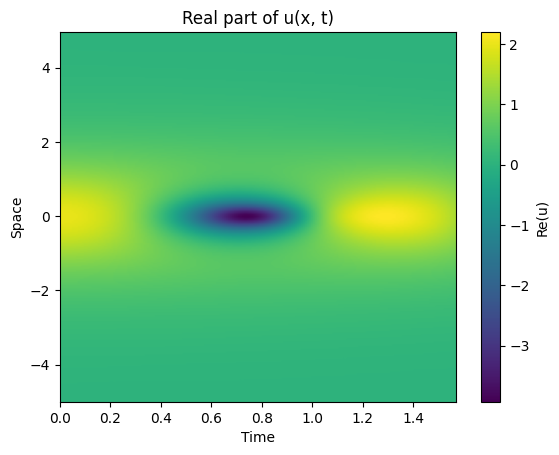

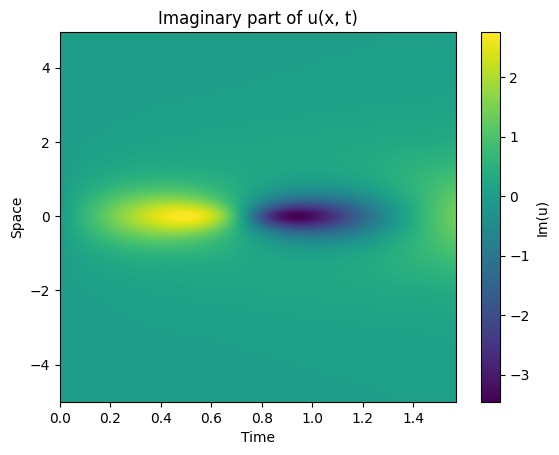

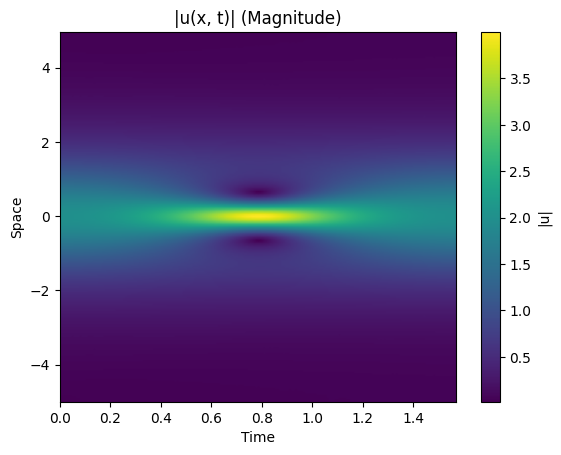

In [9]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np

# Load .mat file
data = scipy.io.loadmat('NLS.mat')

# Extract variables
tt = data['tt'].flatten()   # (201,)
x = data['x'].flatten()     # (256,)
uu = data['uu']             # (256, 201)

#Option 1: Plot the real part
plt.imshow(np.real(uu), extent=[tt[0], tt[-1], x[0], x[-1]],
           aspect='auto', origin='lower')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('Real part of u(x, t)')
plt.colorbar(label='Re(u)')
plt.show()

#Option 2: Plot the imaginary part
plt.imshow(np.imag(uu), extent=[tt[0], tt[-1], x[0], x[-1]],
           aspect='auto', origin='lower')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('Imaginary part of u(x, t)')
plt.colorbar(label='Im(u)')
plt.show()

#Option 3: Plot the magnitude
plt.imshow(np.abs(uu), extent=[tt[0], tt[-1], x[0], x[-1]],
           aspect='auto', origin='lower')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('|u(x, t)| (Magnitude)')
plt.colorbar(label='|u|')
plt.show()


In [ ]:
# Define hyperparameters
input_dim = 2  # tau and S
hidden_dim = 100
output_dim = 1  # Option price
num_hidden_layers = 4
num_epochs = 20000
learning_rate = 0.001
activation_fn = 'tanh'
S_max = 250
tau_max = 1

# Instantiate model and collocation generator
model = model = PINN(
    input_dim=input_dim, 
    hidden_dim=hidden_dim, 
    output_dim=output_dim, 
    num_hidden_layers=num_hidden_layers, 
    activation_fn=activation_fn,
    lb=(0,0),
    ub=(tau_max,S_max),
    out_scale=S_max
)
params = BlackScholesParams(K=100, r=0.05, sigma=0.2)
option = BlackScholesCall(params)
collocation = CollocationBlackScholes(option, tau_max=tau_max, S_max=S_max, n_collocation=1000, n_boundary=100)
differential = BlackScholesDifferential(option)

optimizer_lbfgs = torch.optim.LBFGS(
    model.parameters(),
    lr=1.0,
    max_iter=50000,
    max_eval=50000,
    history_size=50,
    line_search_fn='strong_wolfe',
    tolerance_change=np.finfo(float).eps,
    tolerance_grad=1e-9
)

# Train the PINN
trained_model = train_pinn(
    model=model,
    collocation=collocation,
    differential=differential,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    gamma = 0.9,
    optimizer_lbfgs = optimizer_lbfgs
)

/mnt/c/Meril/Python/1D_BS_SE_pinn-black-scholes-main/1dSE/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([2000, 2])) that is different to the input size (torch.Size([2000, 0])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (0) must match the size of tensor b (2) at non-singleton dimension 1

In [3]:
num_points = 100
S_vals = np.linspace(collocation.S_range[0], collocation.S_range[1], num_points)
tau_vals = np.linspace(collocation.tau_range[0], collocation.tau_range[1], num_points)
S_grid, tau_grid = np.meshgrid(S_vals, tau_vals)
grid = np.column_stack([tau_grid.flatten(), S_grid.flatten()])

In [4]:
inputs_tensor = torch.tensor(grid, dtype=torch.float32)

In [5]:
with torch.no_grad():
    pinn_prices = trained_model(inputs_tensor).numpy().reshape(num_points, num_points)
    if trained_model.out_scale:
        pinn_prices *= trained_model.out_scale

In [6]:
bs_prices = calculate_option_price(
        option=option,
        S=grid[:, 1],
        tau=grid[:, 0]
    ).reshape(num_points, num_points)

c:\Users\Yanni\OneDrive\Documenten\Programming\pinn-black-scholes\src\blackscholes.py:29: RuntimeWarning: divide by zero encountered in log
  (np.log(S / self.K) + (self.r + 0.5 * self.sigma**2) * tau) / (self.sigma * np.sqrt(tau)),
c:\Users\Yanni\OneDrive\Documenten\Programming\pinn-black-scholes\src\blackscholes.py:29: RuntimeWarning: divide by zero encountered in divide
  (np.log(S / self.K) + (self.r + 0.5 * self.sigma**2) * tau) / (self.sigma * np.sqrt(tau)),


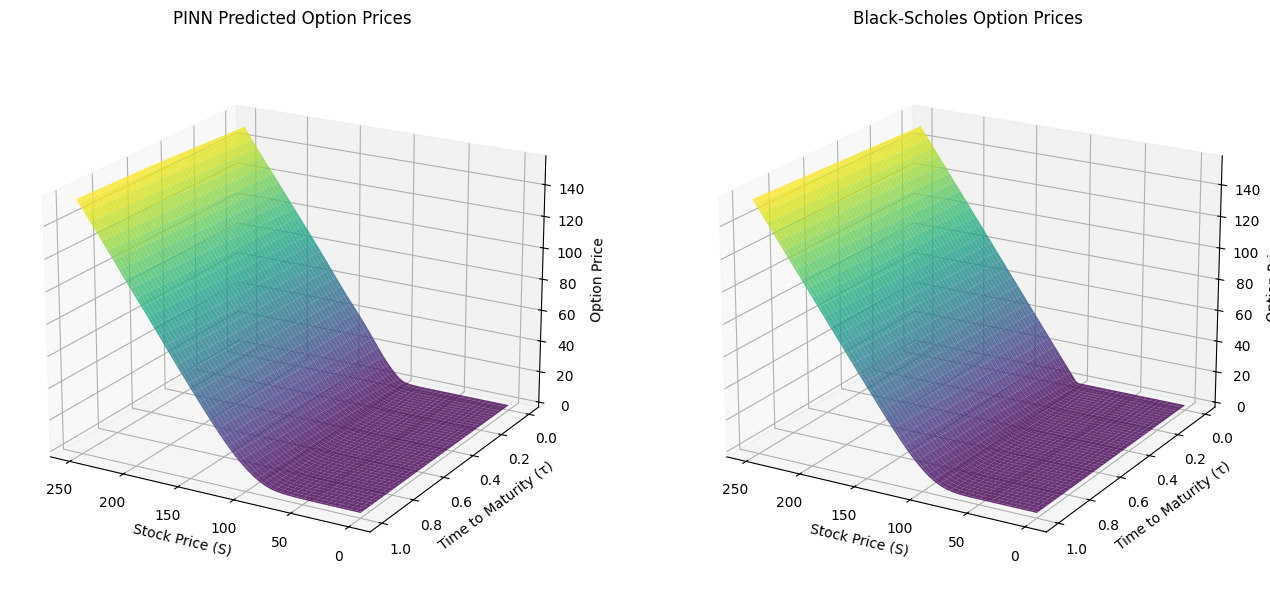

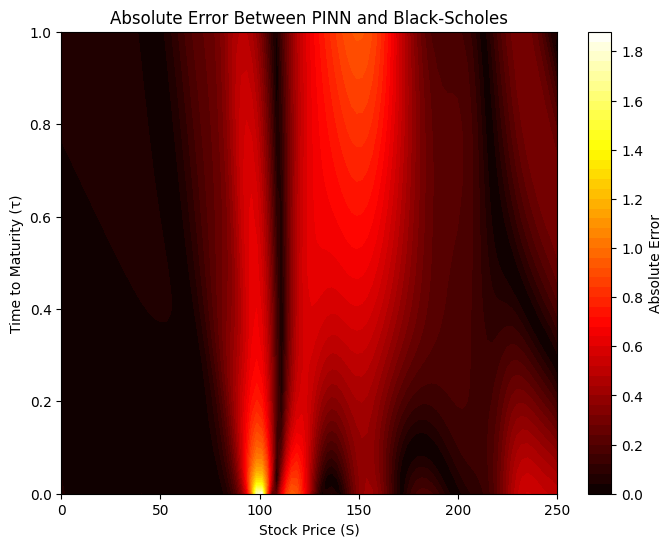

In [7]:
fig = plt.figure(figsize=(16, 8))

# PINN predictions
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(S_grid, tau_grid, pinn_prices, cmap="viridis", alpha=0.8)
ax1.set_title("PINN Predicted Option Prices")
ax1.set_xlabel("Stock Price (S)")
ax1.set_ylabel("Time to Maturity (τ)")
ax1.set_zlabel("Option Price")
ax1.view_init(elev=20, azim=120)

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(S_grid, tau_grid, bs_prices, cmap="viridis", alpha=0.8)
ax2.set_title("Black-Scholes Option Prices")
ax2.set_xlabel("Stock Price (S)")
ax2.set_ylabel("Time to Maturity (τ)")
ax2.set_zlabel("Option Price")
ax2.view_init(elev=20, azim=120)

plt.show()

absolute_error = np.abs(bs_prices - pinn_prices)

plt.figure(figsize=(8, 6))
plt.contourf(S_grid, tau_grid, absolute_error, levels=50, cmap="hot")
plt.colorbar(label="Absolute Error")
plt.title("Absolute Error Between PINN and Black-Scholes")
plt.xlabel("Stock Price (S)")
plt.ylabel("Time to Maturity (τ)")
plt.show()